# RQ1 Analysis (feasability and scalability)

## Filtering out invalid models

In [69]:
import re
import pandas as pd

# Extract model names from the log file
with open('../results/RQ1/ecore/invalid_models_log.txt', "r", encoding="utf-8") as f:
    log_content = f.read()

model_names_to_remove = re.findall(r"error loading model:\s+(.+?)\s+with", log_content)

df = pd.read_csv("../results/RQ1/ecore/models.csv")

# Filter out rows where 'model' is in the list of models to remove
filtered_df = df[~df['model'].isin(model_names_to_remove)]
cols = ['classes', 'attributes', 'refs', 'containments']
# removing models with only data type elements (no structural elements)
filtered_df = filtered_df[~(df[cols] == 0).all(axis=1)]
filtered_df.to_csv("../results/RQ1/ecore/valid_models.csv", index=False)

print(f"Removed {len(df) - len(filtered_df)} rows. {len(filtered_df)} Saved to 'valid_models.csv'.")


Removed 329 rows. 2091 Saved to 'valid_models.csv'.


C:\Users\lamp6\AppData\Local\Temp\ipykernel_23436\1869417040.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  filtered_df = filtered_df[~(df[cols] == 0).all(axis=1)]


## Plotting model's data

In [70]:
import pandas as pd

df = pd.read_csv('../results/RQ1/ecore/valid_models.csv')
df.info

<bound method DataFrame.info of                   model   LOC  classes  attributes  refs  containments
0              .skriven    47        6           8     2             0
1          101companies    37        3           7     0             4
2               abapobj   220       13          47     7            13
3                 ABase    23        5           4     0             0
4                   ABC    18        3           0     0             0
...                 ...   ...      ...         ...   ...           ...
2086  ZEvesProofProcess    29        4           5     0             0
2087                Zoo    29        9           1     0             4
2088        zvisclasses    36        5          10     1             3
2089                 _0  3188       86         151     0           104
2090             µOCCAM   177       57          26     0            44

[2091 rows x 6 columns]>

In [71]:
import pandas as pd

# Compute total
df['total'] = df[['classes', 'attributes', 'refs', 'containments']].sum(axis=1)

# Columns to summarize
cols = ['classes', 'attributes', 'refs', 'containments', 'total']

# Compute statistics
summary = df[cols].agg(['min', 'median', 'mean', 'max', 'std'])

# Rename 'mean' to 'avg'
summary = summary.rename(index={'mean': 'avg'})
summary = summary.loc[['min', 'median', 'avg','max', 'std']] 

# Transpose so metrics become columns
summary = summary.T

# Generate LaTeX table with bold row labels
latex_table = r"""\begin{table}[t]
\centering
\caption{Metamodel Statistics}
\label{tab:metamodelstats}
\footnotesize
\addtolength{\tabcolsep}{-2pt}
\begin{tabular}{lrrrrr}
\toprule
\textbf{Metrics} & min & median & avg & max & std \\
\midrule
"""

for idx, row in summary.iterrows():
    latex_table += f"\\textbf{{{idx}}} & {int(row['min'])} & {int(row['median'])} & {row['avg']:.2f} & {int(row['max'])} & {row['std']:.2f} \\\\\n"

latex_table += r"""\bottomrule
\end{tabular}
\end{table}
"""

print(latex_table)


\begin{table}[t]
\centering
\caption{Metamodel Statistics}
\label{tab:metamodelstats}
\footnotesize
\addtolength{\tabcolsep}{-2pt}
\begin{tabular}{lrrrrr}
\toprule
\textbf{Metrics} & min & median & avg & max & std \\
\midrule
\textbf{classes} & 1 & 9 & 25.49 & 945 & 64.57 \\
\textbf{attributes} & 0 & 8 & 31.35 & 7933 & 203.80 \\
\textbf{refs} & 0 & 3 & 12.92 & 1262 & 54.11 \\
\textbf{containments} & 0 & 4 & 16.00 & 1291 & 49.47 \\
\textbf{total} & 1 & 30 & 85.76 & 8410 & 288.59 \\
\bottomrule
\end{tabular}
\end{table}



C:\Users\lamp6\AppData\Local\Temp\ipykernel_23436\140820937.py:13: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = ax.boxplot(


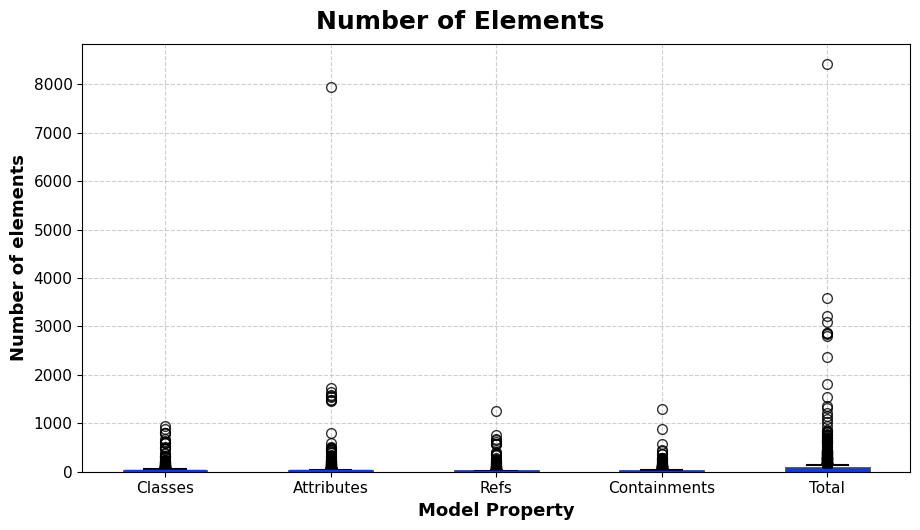

In [72]:
import pandas as pd
import matplotlib.pyplot as plt

valid_df = pd.read_csv('../results/RQ1/ecore/valid_models.csv')
props = ['classes', 'attributes', 'refs', 'containments']

valid_df['total'] = valid_df[props].sum(axis=1)
data = [valid_df[prop].values for prop in props] + [valid_df['total'].values]

fig, ax = plt.subplots(figsize=(9, 5))
fig.suptitle('Number of Elements', fontsize=18, fontweight='bold', y=1.02)

box = ax.boxplot(
    data,
    vert=True,
    patch_artist=True,
    labels=[p.capitalize() for p in props] + ['Total'],
    boxprops=dict(facecolor='#AFCBFF', color='black', linewidth=2, alpha=0.7),
    medianprops=dict(color="#0B3AF7", linewidth=2.5),
    whiskerprops=dict(color='black', linewidth=1.5),
    capprops=dict(color='black', linewidth=1.5),
    flierprops=dict(marker='o', color='red', alpha=0.8, markersize=7),   
)

ax.set_xlabel('Model Property', fontsize=13, fontweight='bold')
ax.set_ylabel('Number of elements', fontsize=13, fontweight='bold')
ax.tick_params(axis='x', labelsize=11)
ax.tick_params(axis='y', labelsize=11)
ax.grid(True, linestyle='--', alpha=0.6)

    
ax.set_ylim(bottom=0)
plt.tight_layout(pad=0)
plt.savefig("img/rq1models.pdf", format='pdf', bbox_inches='tight') 
plt.show()

# Results

## Summary

### Summary of the results

In [73]:
import pandas as pd 
import glob

# Load valid models
valid_df = pd.read_csv('../results/RQ1/ecore/valid_models.csv')

# Find all models_run_*.csv files
run_files = glob.glob('../results/RQ1/ecore/models_run_*.csv')

dfs_ = []
for f in run_files:
    df = pd.read_csv(f)
    dfs_.append(df)

# Combine all run files into a single DataFrame
runs_df_ = pd.concat([pd.read_csv(f) for f in run_files], ignore_index=True)

# Merge with valid_df on 'model' column (inner join keeps only valid models)
combined_df_ = pd.merge(runs_df_, valid_df, on='model', suffixes=('_run', '_model'))

all_times_ = []
all_mem_ = []
for file in run_files:
    df = pd.read_csv(file)
    all_times_.extend(df['time'].values)
    all_mem_.extend(df['mem'].values)

all_times_ = pd.Series(all_times_)
print(f"Number of runs analyzed: {len(run_files)}")
print(f"Min time: {all_times_.min():.2f} ms")
print(f"Max time: {all_times_.max():.2f} ms")
print(f"Avg time: {all_times_.mean():.2f} ms")

all_mem_ = pd.Series(all_mem_) 
print(f"Min memory: {all_mem_.min():.2f} KB")
print(f"Max memory: {all_mem_.max():.2f} KB")
print(f"Avg memory: {all_mem_.mean():.2f} KB")

Number of runs analyzed: 30
Min time: 3.00 ms
Max time: 2726.00 ms
Avg time: 13.63 ms
Min memory: 151.00 KB
Max memory: 45979.00 KB
Avg memory: 850.88 KB


In [74]:
import pandas as pd  

dfs = [pd.read_csv(f) for f in run_files]
all_runs = pd.concat(dfs, ignore_index=True)

# Group by 'model' and compute the mean for each metric
avg_df = all_runs.groupby('model', as_index=False).mean(numeric_only=True)

# Get the top 10 models sorted by descending average time
avg_df = avg_df.sort_values('time', ascending=False)

avg_df.head(10)

,model,nodes,edges,time,mem
979,acad,69.0,68.0,615.666667,676.933333
1028,atm,103.0,102.0,612.766667,799.300000
1855,scheduler,57.0,56.0,605.633333,517.666667
1358,format,9514.0,12936.0,528.733333,44147.966667
1884,sgraph,63.0,108.0,421.666667,753.166667
107,CIM15,4371.0,7722.0,279.300000,18488.433333
392,IFC2X4_RC3,5117.0,7391.0,251.333333,13715.633333
1455,ifc2x3,4487.0,6350.0,228.666667,12006.733333
1456,ifc2x3tc1,4497.0,6369.0,227.966667,17374.033333
391,IFC2X3_TC1,3351.0,5223.0,175.033333,14099.866667


## Considering Time (ms)

C:\Users\lamp6\AppData\Local\Temp\ipykernel_23436\2967077759.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  blues = cm.get_cmap('Blues', num_runs + 2)


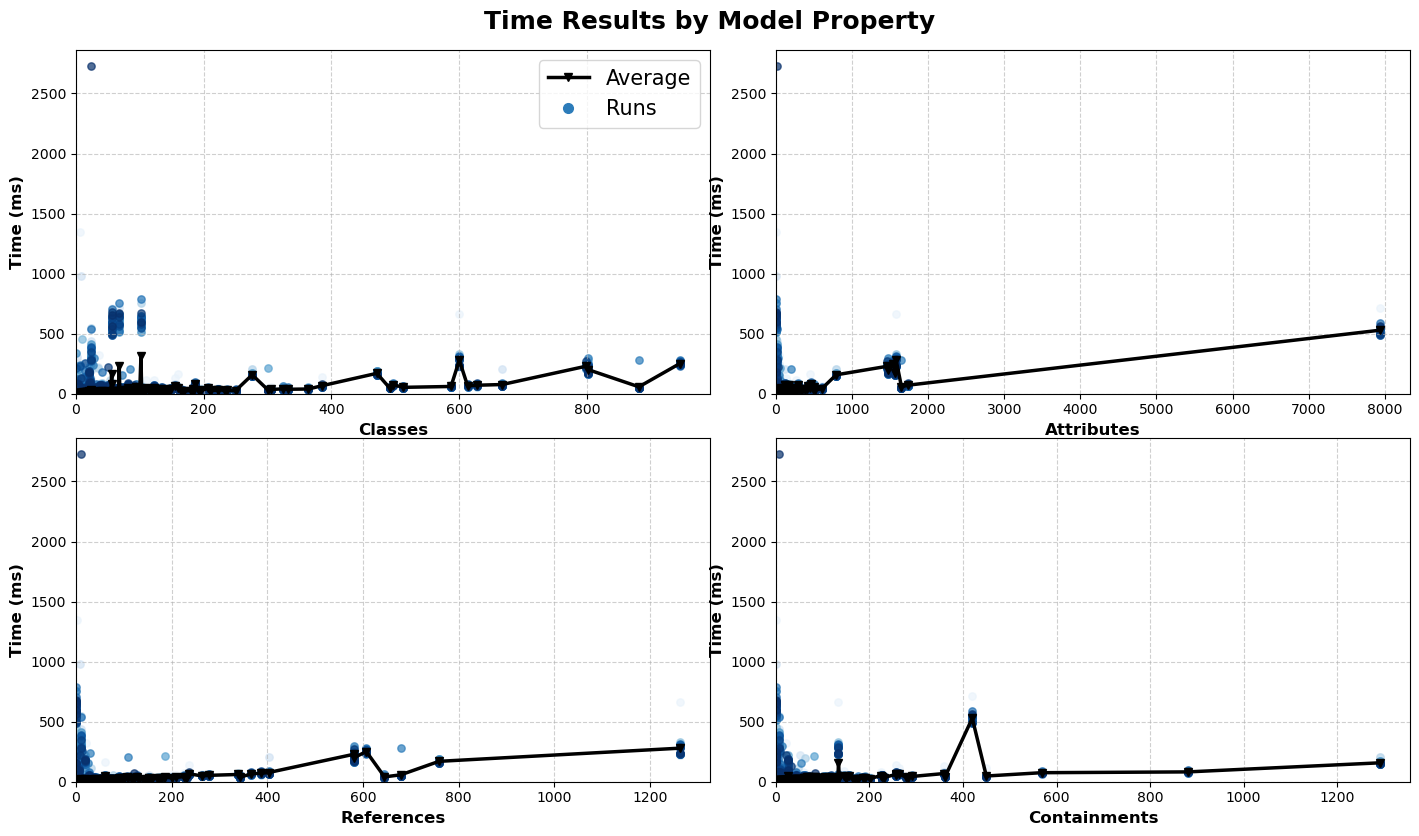

In [75]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.lines as mlines

num_runs = len(dfs)
blues = cm.get_cmap('Blues', num_runs + 2)
colors = [blues(i + 2) for i in range(num_runs)]

props = ['classes', 'attributes', 'refs', 'containments']
xlabel_map = {'refs': 'References'}

for i, df in enumerate(dfs):
    df['run'] = i
runs_df = pd.concat(dfs, ignore_index=True)
combined_df = pd.merge(runs_df, valid_df, on='model', suffixes=('_run', '_model'))

fig, axes = plt.subplots(2, 2, figsize=(14, 8))
fig.suptitle('Time Results by Model Property', fontsize=18, fontweight='bold', y=1.02)

for idx, prop in enumerate(props):
    avg_times = combined_df.groupby(prop)['time'].mean()
    ax = axes[idx // 2, idx % 2]

    # Plot average line
    ax.plot(avg_times.index, avg_times.values, color="#000000", linewidth=2.5, label='Average', marker='v')

    # Scatter plot for each run (without individual legend entries)
    for i in range(num_runs):
        run_df = combined_df[combined_df['run'] == i]
        ax.scatter(run_df[prop], run_df['time'], alpha=0.7, s=28, color=colors[i],rasterized=True)
    ax.set_xlim(left=0)
    ax.set_ylim(bottom=0)
    # Custom x-axis label
    x_label = xlabel_map.get(prop, prop.capitalize())
    ax.set_xlabel(x_label, fontsize=12, fontweight='bold')
    ax.set_ylabel('Time (ms)', fontsize=12, fontweight='bold')
    ax.tick_params(axis='x', labelsize=10)
    ax.tick_params(axis='y', labelsize=10)
    ax.grid(True, linestyle='--', alpha=0.6)
    
        

ax_legend = axes[0, 0]
avg_line = mlines.Line2D([], [], color='black', marker='v', label='Average', linewidth=2.5)
run_marker = mlines.Line2D([], [], color=colors[20], marker='o', linestyle='None', label='Runs', markersize=7)
ax_legend.legend(handles=[avg_line, run_marker], loc='upper right', fontsize=15, frameon=True)

plt.tight_layout(pad=0)
plt.savefig("img/rq1timebymodelprop.pdf", format='pdf', bbox_inches='tight') 
plt.show()


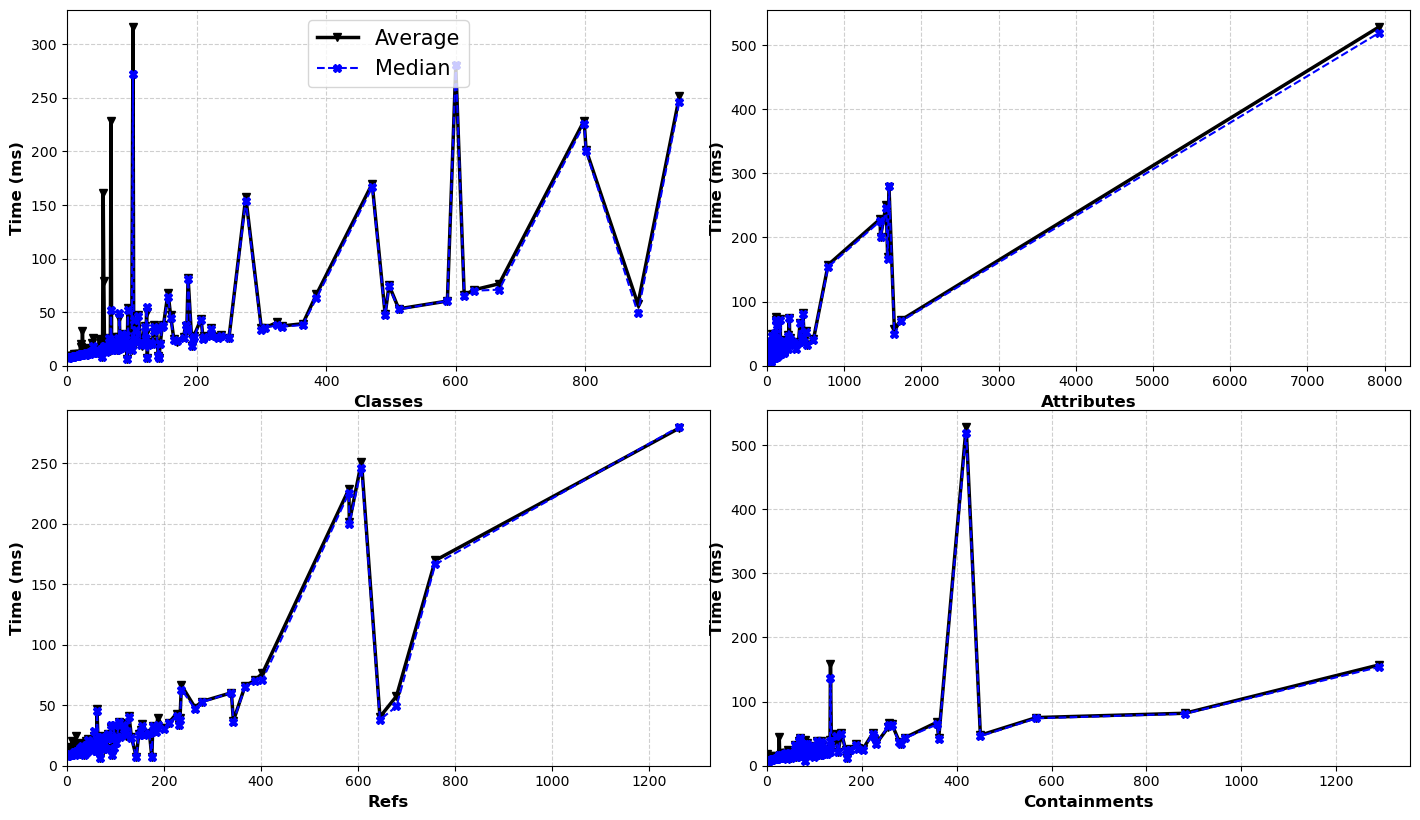

In [76]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
 
# Run index to combined_df for coloring
for i, df in enumerate(dfs):
    df['run'] = i
runs_df = pd.concat(dfs, ignore_index=True)
combined_df = pd.merge(runs_df, valid_df, on='model', suffixes=('_run', '_model'))

fig, axes = plt.subplots(2, 2, figsize=(14, 8))
#fig.suptitle('Time Results by Model Property', fontsize=18, fontweight='bold', y=1.02)

for idx, prop in enumerate(props):
    avg_mem = combined_df.groupby(prop)['time'].mean() 
    med_mem = combined_df.groupby(prop)['time'].median() 
    ax = axes[idx // 2, idx % 2]
    ax.plot(avg_mem.index, avg_mem.values, color='black', linewidth=2.5, label='Average', marker='v')
    ax.plot(med_mem.index, med_mem.values, color='blue', linewidth=1.5, label='Median', marker='X', linestyle='--')
    ax.set_xlabel(prop.capitalize(), fontsize=12, fontweight='bold')
    ax.set_ylabel('Time (ms)', fontsize=12, fontweight='bold')
    ax.tick_params(axis='x', labelsize=10)
    ax.tick_params(axis='y', labelsize=10)
    ax.grid(True, linestyle='--', alpha=0.6)
    
        
    ax.set_ylim(bottom=0)
    ax.set_xlim(left=0)
ax_legend = axes[0, 0]
avg_line = mlines.Line2D([], [], color='black', marker='v', label='Average', linewidth=2.5)
med_line = mlines.Line2D([], [], color='blue', linewidth=1.5, label='Median', marker='X', linestyle='--') 
ax_legend.legend(handles=[avg_line,med_line], loc='upper center', fontsize=15, frameon=True)

plt.tight_layout(pad=0)
plt.savefig("img/rq1timeavg.pdf", format='pdf', bbox_inches='tight') 
plt.show()

C:\Users\lamp6\AppData\Local\Temp\ipykernel_23436\1286003746.py:8: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = ax.boxplot(


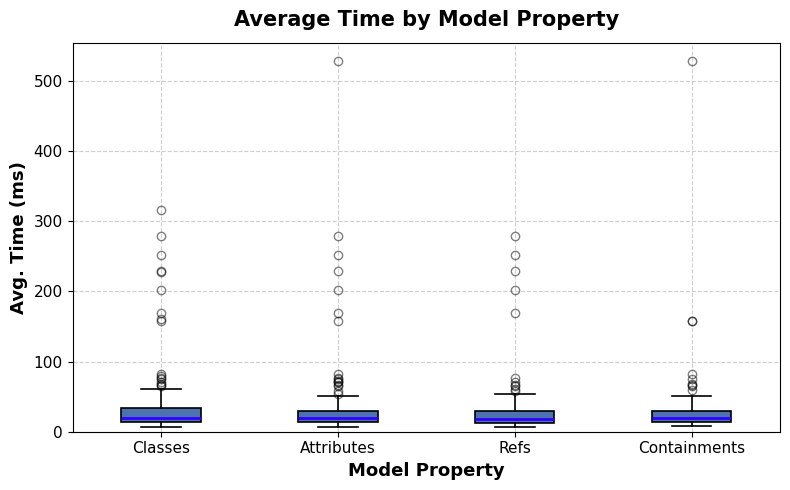

In [77]:
import matplotlib.pyplot as plt 

props = ['classes', 'attributes', 'refs', 'containments']
avg_time_data = [combined_df.groupby(prop)['time'].mean().values for prop in props]

fig, ax = plt.subplots(figsize=(8, 5))

box = ax.boxplot(
    avg_time_data,
    vert=True,
    patch_artist=True,
    labels=[p.capitalize() for p in props],
    boxprops=dict(facecolor='#4C72B0', color='black', linewidth=1.2),
    medianprops=dict(color="#2F00FF", linewidth=2),
    whiskerprops=dict(color='black', linewidth=1.2),
    capprops=dict(color='black', linewidth=1.2),
    flierprops=dict(marker='o', color='gray', alpha=0.5)
)

ax.set_xlabel('Model Property', fontsize=13, fontweight='bold')
ax.set_ylabel('Avg. Time (ms)', fontsize=13, fontweight='bold')
ax.set_title('Average Time by Model Property', fontsize=15, fontweight='bold', pad=12)
ax.tick_params(axis='x', labelsize=11)
ax.tick_params(axis='y', labelsize=11)
ax.grid(True, linestyle='--', alpha=0.6)
ax.set_ylim(bottom=0)

    

plt.tight_layout()
plt.show()

C:\Users\lamp6\AppData\Local\Temp\ipykernel_23436\2059208689.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  blues = cm.get_cmap('Blues', num_runs + 2)


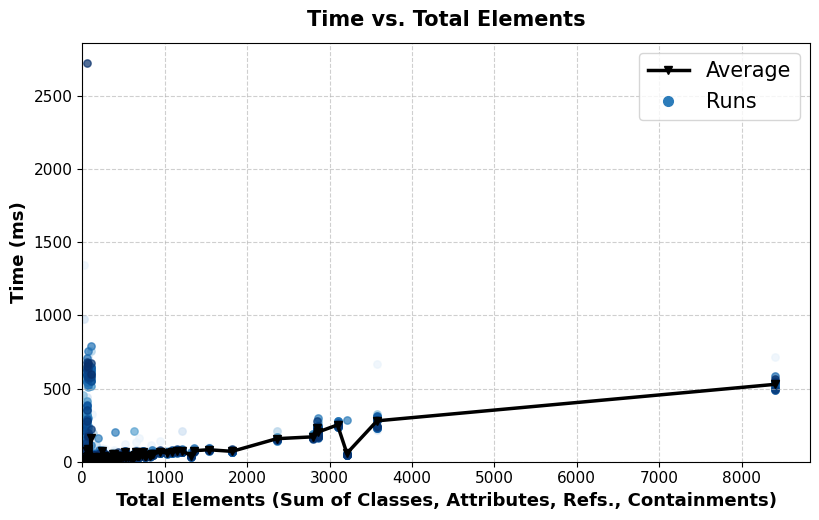

In [78]:
import matplotlib.pyplot as plt 
import matplotlib.cm as cm

num_runs = len(dfs)
blues = cm.get_cmap('Blues', num_runs + 2)
colors = [blues(i + 2) for i in range(num_runs)]

valid_df['total_structural'] = valid_df[['classes', 'attributes', 'refs', 'containments']].sum(axis=1)
model_total_structural = valid_df.set_index('model')['total_structural'] 
for df in dfs:
    df['total_structural'] = df['model'].map(model_total_structural) 
combined_df_total = pd.concat(dfs)
 
avg_times = combined_df_total.groupby('total_structural')['time'].mean()
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(avg_times.index, avg_times.values, color="#000000", linewidth=2.5, label='Average', marker='v')

#markers = ['o', 's', '^', 'D', 'P', 'X', '*', 'v']
for i, df in enumerate(dfs):
    #marker_style = markers[i % len(markers)]
    ax.scatter(df['total_structural'], df['time'], label=f'Run {i+1}', alpha=0.7, s=28,  color=colors[i]
               ,rasterized=True)
ax.set_xlabel('Total Elements (Sum of Classes, Attributes, Refs., Containments)', fontsize=13, fontweight='bold')
ax.set_ylabel('Time (ms)', fontsize=13, fontweight='bold')
ax.set_title('Time vs. Total Elements', fontsize=15, fontweight='bold', pad=12)
ax.tick_params(axis='x', labelsize=11)
ax.tick_params(axis='y', labelsize=11)
ax.grid(True, linestyle='--', alpha=0.6)
#ax.legend(fontsize=10, loc='best')
avg_line = mlines.Line2D([], [], color='black', marker='v', label='Average', linewidth=2.5)
run_marker = mlines.Line2D([], [], color=colors[20], marker='o', linestyle='None', label='Runs', markersize=7)
ax.legend(handles=[avg_line, run_marker], loc='upper right', fontsize=15, frameon=True)
ax.set_ylim(bottom=0)
ax.set_xlim(left=0)

    

# ax.set_xlim(0, 3300) 
plt.tight_layout(pad=0)
plt.savefig("img/rq1timebymodel.pdf", format='pdf', bbox_inches='tight') 
plt.show()

## Considering memory (KB)

C:\Users\lamp6\AppData\Local\Temp\ipykernel_23436\2966636762.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  blues = cm.get_cmap('Blues', num_runs + 2)


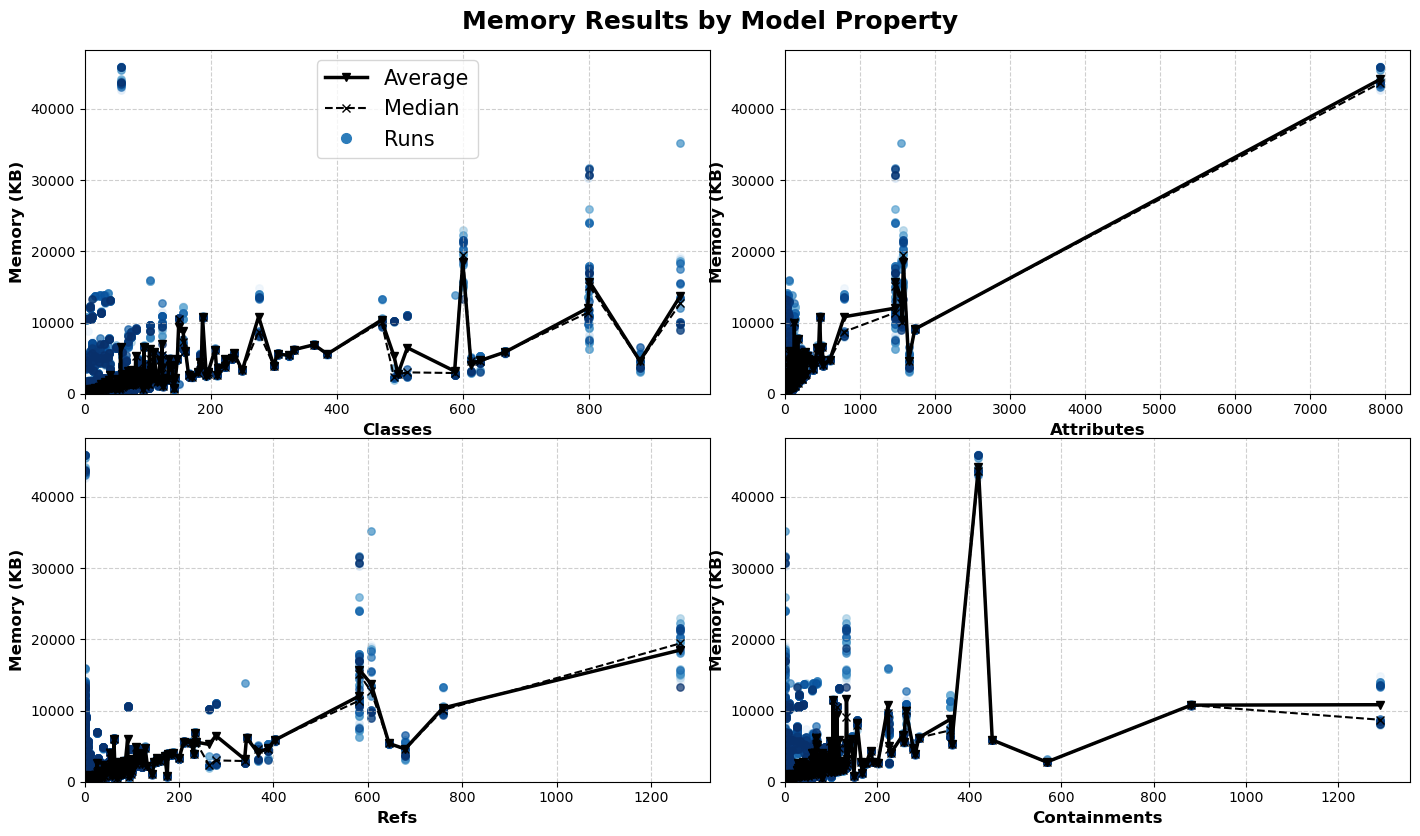

In [79]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

num_runs = len(dfs)
blues = cm.get_cmap('Blues', num_runs + 2)
colors = [blues(i + 2) for i in range(num_runs)]

props = ['classes', 'attributes', 'refs', 'containments']
markers = ['o', 's', '^', 'D', 'P', 'X', '*', 'v']

# Run index to combined_df for coloring
for i, df in enumerate(dfs):
    df['run'] = i
runs_df = pd.concat(dfs, ignore_index=True)
combined_df = pd.merge(runs_df, valid_df, on='model', suffixes=('_run', '_model'))

fig, axes = plt.subplots(2, 2, figsize=(14, 8))
fig.suptitle('Memory Results by Model Property', fontsize=18, fontweight='bold', y=1.02)

for idx, prop in enumerate(props):
    avg_mem = combined_df.groupby(prop)['mem'].mean()
    med_mem = combined_df.groupby(prop)['mem'].median()
    ax = axes[idx // 2, idx % 2]
    ax.plot(avg_mem.index, avg_mem.values, color='black', linewidth=2.5, label='Average', marker='v')
    ax.plot(med_mem.index, med_mem.values, color='black', linewidth=1.5, label='Median', marker='x', linestyle='--')
    for i in range(num_runs):
        run_df = combined_df[combined_df['run'] == i]
        marker_style = markers[i % len(markers)]
        ax.scatter(run_df[prop], run_df['mem'], label=f'Run {i+1}', alpha=0.7, s=28, color=colors[i], rasterized=True)
    ax.set_xlabel(prop.capitalize(), fontsize=12, fontweight='bold')
    ax.set_ylabel('Memory (KB)', fontsize=12, fontweight='bold')
    ax.tick_params(axis='x', labelsize=10)
    ax.tick_params(axis='y', labelsize=10)
    ax.grid(True, linestyle='--', alpha=0.6)
    
        
    ax.set_ylim(bottom=0)
    ax.set_xlim(left=0)
ax_legend = axes[0, 0]
avg_line = mlines.Line2D([], [], color='black', marker='v', label='Average', linewidth=2.5)
med_line = mlines.Line2D([], [], color='black', linewidth=1.5, label='Median', marker='x', linestyle='--')
run_marker = mlines.Line2D([], [], color=colors[20], marker='o', linestyle='None', label='Runs', markersize=7)
ax_legend.legend(handles=[avg_line,med_line,run_marker], loc='upper center', fontsize=15, frameon=True)

plt.tight_layout(pad=0)
plt.savefig("img/rq1membymodelprop.pdf", format='pdf', bbox_inches='tight') 
plt.show()

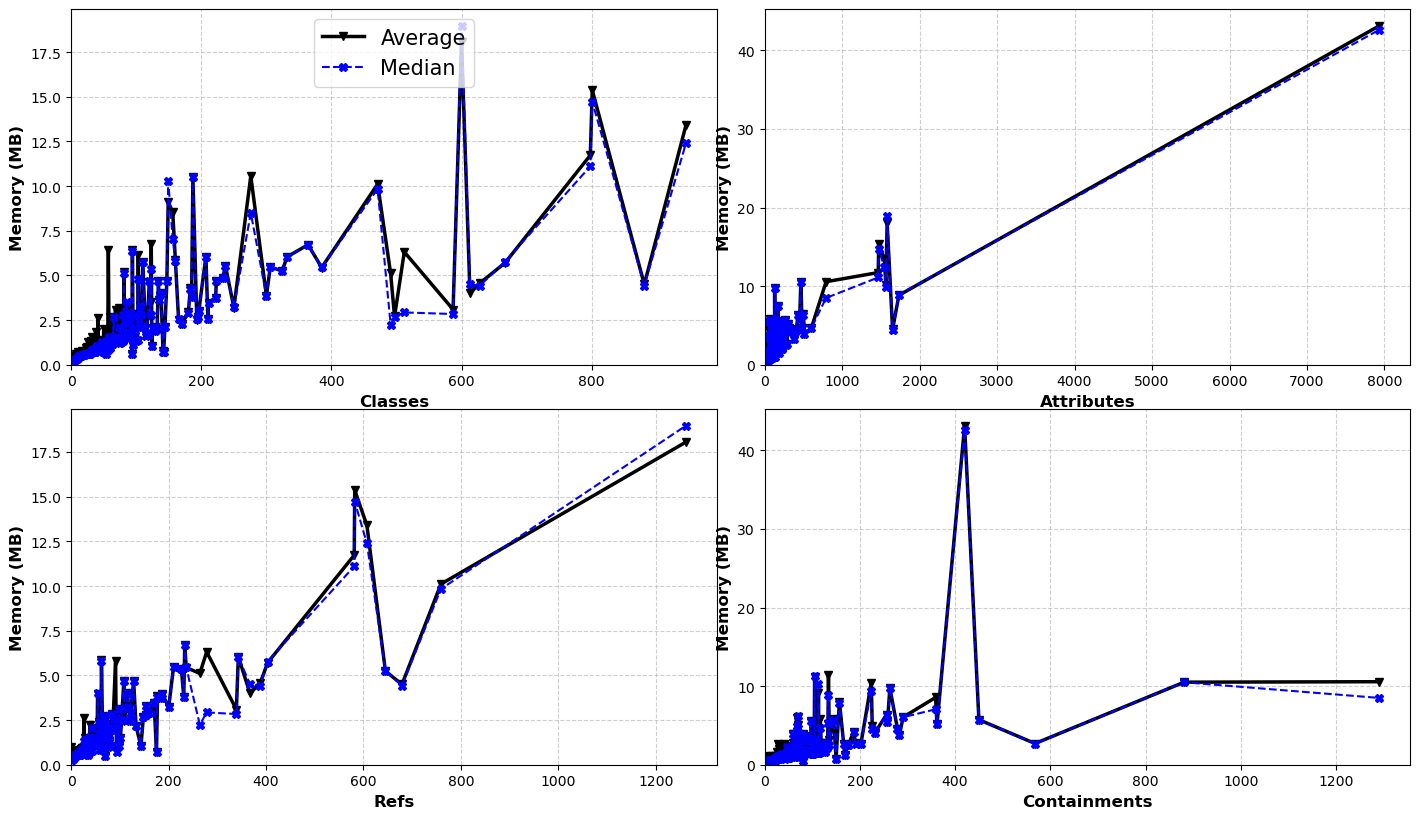

In [80]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
 
# Run index to combined_df for coloring
for i, df in enumerate(dfs):
    df['run'] = i
runs_df = pd.concat(dfs, ignore_index=True)
combined_df = pd.merge(runs_df, valid_df, on='model', suffixes=('_run', '_model'))

fig, axes = plt.subplots(2, 2, figsize=(14, 8))
#fig.suptitle('Memory Results by Model Property', fontsize=18, fontweight='bold', y=1.02)

for idx, prop in enumerate(props):
    avg_mem = combined_df.groupby(prop)['mem'].mean() / 1024         # KB to MB
    med_mem = combined_df.groupby(prop)['mem'].median() / 1024         # KB to MB
    ax = axes[idx // 2, idx % 2]
    ax.plot(avg_mem.index, avg_mem.values, color='black', linewidth=2.5, label='Average', marker='v')
    ax.plot(med_mem.index, med_mem.values, color='blue', linewidth=1.5, label='Median', marker='X', linestyle='--')
    ax.set_xlabel(prop.capitalize(), fontsize=12, fontweight='bold')
    ax.set_ylabel('Memory (MB)', fontsize=12, fontweight='bold')
    ax.tick_params(axis='x', labelsize=10)
    ax.tick_params(axis='y', labelsize=10)
    ax.grid(True, linestyle='--', alpha=0.6)
    
        
    ax.set_ylim(bottom=0)
    ax.set_xlim(left=0)
ax_legend = axes[0, 0]
avg_line = mlines.Line2D([], [], color='black', marker='v', label='Average', linewidth=2.5)
med_line = mlines.Line2D([], [], color='blue', linewidth=1.5, label='Median', marker='X', linestyle='--') 
ax_legend.legend(handles=[avg_line,med_line], loc='upper center', fontsize=15, frameon=True)

plt.tight_layout(pad=0)
plt.savefig("img/rq1memavg.pdf", format='pdf', bbox_inches='tight') 
plt.show()

C:\Users\lamp6\AppData\Local\Temp\ipykernel_23436\3162900991.py:8: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = ax.boxplot(


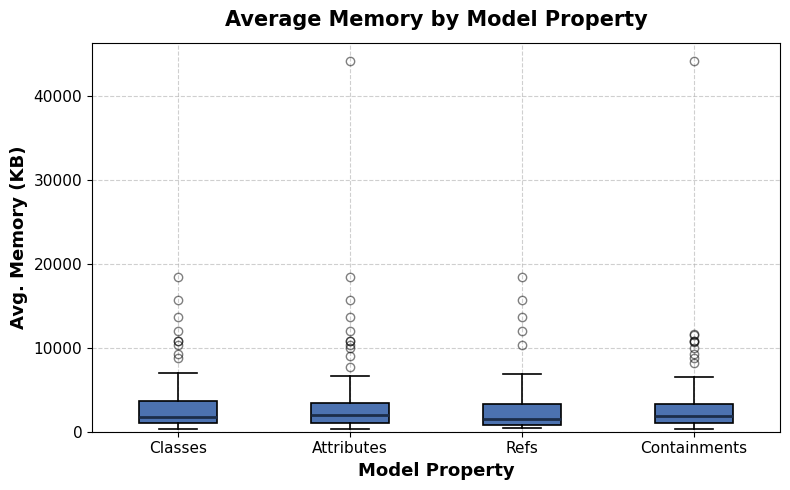

In [81]:
import matplotlib.pyplot as plt 

props = ['classes', 'attributes', 'refs', 'containments']
avg_mem_data = [combined_df.groupby(prop)['mem'].mean().values for prop in props]

fig, ax = plt.subplots(figsize=(8, 5))

box = ax.boxplot(
    avg_mem_data,
    vert=True,
    patch_artist=True,
    labels=[p.capitalize() for p in props],
    boxprops=dict(facecolor='#4C72B0', color='black', linewidth=1.2),
    medianprops=dict(color="#1B2D49", linewidth=2),
    whiskerprops=dict(color='black', linewidth=1.2),
    capprops=dict(color='black', linewidth=1.2),
    flierprops=dict(marker='o', color='gray', alpha=0.5)
)

ax.set_xlabel('Model Property', fontsize=13, fontweight='bold')
ax.set_ylabel('Avg. Memory (KB)', fontsize=13, fontweight='bold')
ax.set_title('Average Memory by Model Property', fontsize=15, fontweight='bold', pad=12)
ax.tick_params(axis='x', labelsize=11)
ax.tick_params(axis='y', labelsize=11)
ax.grid(True, linestyle='--', alpha=0.6)
ax.set_ylim(bottom=0)

    

plt.tight_layout()
plt.show()

C:\Users\lamp6\AppData\Local\Temp\ipykernel_23436\2198474148.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  blues = cm.get_cmap('Blues', num_runs + 2)


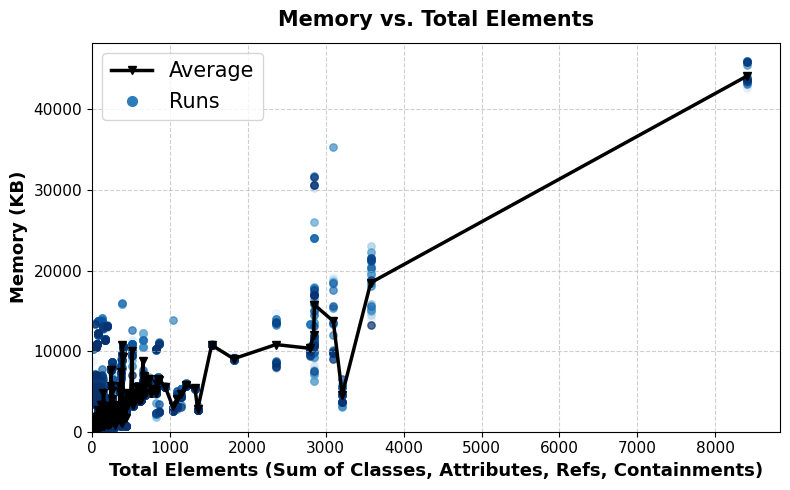

In [82]:
import matplotlib.pyplot as plt 
import matplotlib.cm as cm

num_runs = len(dfs)
blues = cm.get_cmap('Blues', num_runs + 2)
colors = [blues(i + 2) for i in range(num_runs)]

valid_df['total_structural'] = valid_df[['classes', 'attributes', 'refs', 'containments']].sum(axis=1)
model_total_structural = valid_df.set_index('model')['total_structural']


for df in dfs:
    df['total_structural'] = df['model'].map(model_total_structural)


combined_df_total = pd.concat(dfs)  
avg_mems = combined_df_total.groupby('total_structural')['mem'].mean()

fig, ax = plt.subplots(figsize=(8, 5))


ax.plot(avg_mems.index, avg_mems.values, color="#000000", linewidth=2.5, label='Average', marker='v')

for i, df in enumerate(dfs):
    ax.scatter(df['total_structural'], df['mem'], label=f'Run {i+1}', alpha=0.7, s=28, color=colors[i], rasterized=True)
ax.set_xlabel('Total Elements (Sum of Classes, Attributes, Refs, Containments)', fontsize=13, fontweight='bold')
ax.set_ylabel('Memory (KB)', fontsize=13, fontweight='bold')
ax.set_title('Memory vs. Total Elements', fontsize=15, fontweight='bold', pad=12)
ax.tick_params(axis='x', labelsize=11)
ax.tick_params(axis='y', labelsize=11)
ax.grid(True, linestyle='--', alpha=0.6)
ax.set_ylim(bottom=0)
ax.set_xlim(left=0)
#ax.legend(fontsize=10, loc='best')


    

avg_line = mlines.Line2D([], [], color='black', marker='v', label='Average', linewidth=2.5)
run_marker = mlines.Line2D([], [], color=colors[20], marker='o', linestyle='None', label='Runs', markersize=7)
ax.legend(handles=[avg_line, run_marker], loc='upper left', fontsize=15, frameon=True)
# ax.set_xlim(0, 3300) 
plt.tight_layout()
plt.savefig("img/rq1membymodel.pdf", format='pdf', bbox_inches='tight') 
plt.show()

## Considering the size of the graphs (nodes and edges)

C:\Users\lamp6\AppData\Local\Temp\ipykernel_23436\3742947143.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  blues = cm.get_cmap('Blues', num_runs + 2)


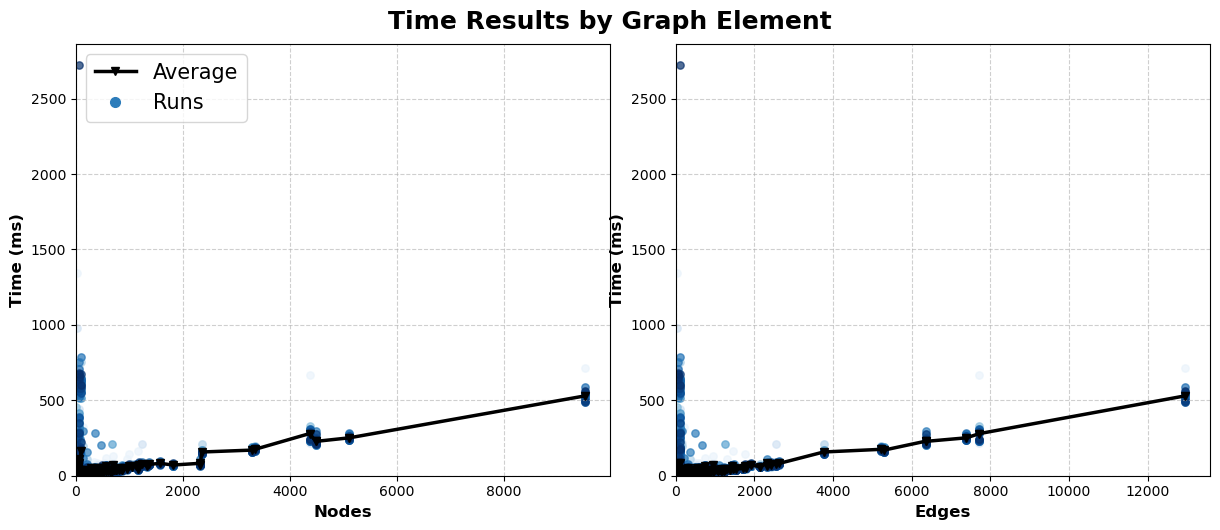

In [83]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

num_runs = len(dfs)
blues = cm.get_cmap('Blues', num_runs + 2)
colors = [blues(i + 2) for i in range(num_runs)]

props = ['nodes', 'edges']

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle('Time Results by Graph Element', fontsize=18, fontweight='bold', y=1.02)

for idx, prop in enumerate(props):
    avg_time = combined_df.groupby(prop)['time'].mean()
    ax = axes[idx]
    # Plot average line
    ax.plot(avg_time.index, avg_time.values, color="#000000", linewidth=2.5, label='Average', marker='v')
    # Plot each run with a different marker
    for i, df in enumerate(dfs):
        ax.scatter(df[prop], df['time'], label=f'Run {i+1}', alpha=0.7, s=28,color=colors[i], rasterized=True)
    ax.set_xlabel(prop.capitalize(), fontsize=12, fontweight='bold')
    ax.set_ylabel('Time (ms)', fontsize=12, fontweight='bold')
    ax.tick_params(axis='x', labelsize=10)
    ax.tick_params(axis='y', labelsize=10)
    ax.grid(True, linestyle='--', alpha=0.6)
    ax.set_ylim(bottom=0)
    ax.set_xlim(left=0)
    
        
   # if idx == 0:
       # ax.legend(fontsize=10, loc='best')
ax_legend = axes[0]
avg_line = mlines.Line2D([], [], color='black', marker='v', label='Average', linewidth=2.5)
run_marker = mlines.Line2D([], [], color=colors[20], marker='o', linestyle='None', label='Runs', markersize=7)
ax_legend.legend(handles=[avg_line, run_marker], loc='upper left', fontsize=15, frameon=True)
plt.tight_layout(pad=0)
plt.savefig("img/rq1timenodesedges.pdf", format='pdf', bbox_inches='tight') 
plt.show()

C:\Users\lamp6\AppData\Local\Temp\ipykernel_23436\2993008939.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  blues = cm.get_cmap('Blues', num_runs + 2)


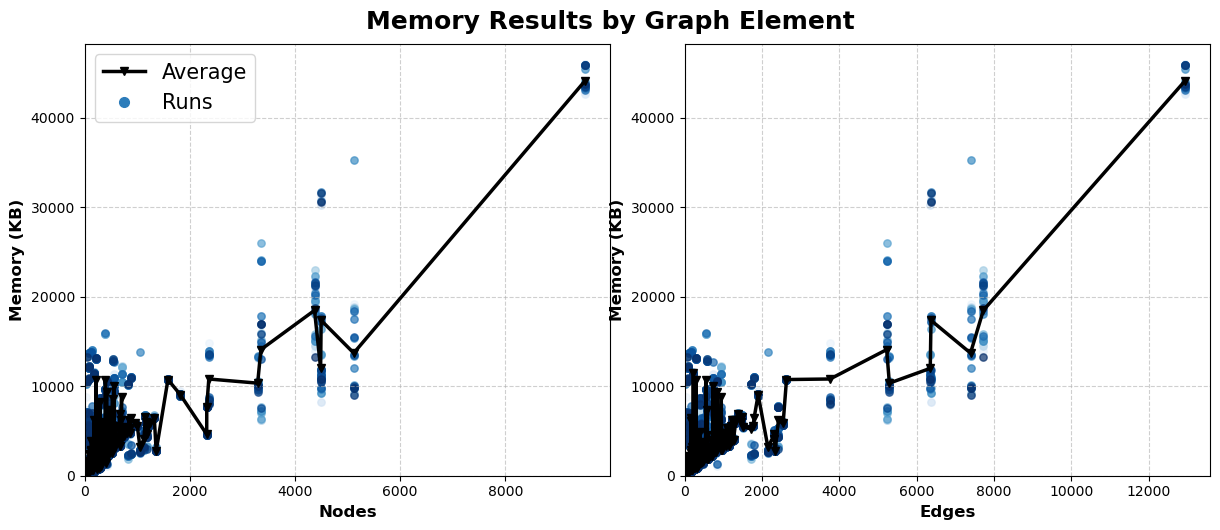

In [84]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

num_runs = len(dfs)
blues = cm.get_cmap('Blues', num_runs + 2)
colors = [blues(i + 2) for i in range(num_runs)]

props = ['nodes', 'edges']

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle('Memory Results by Graph Element', fontsize=18, fontweight='bold', y=1.02)

for idx, prop in enumerate(props):
    avg_mem = combined_df.groupby(prop)['mem'].mean()
    ax = axes[idx]
    # Plot average line
    ax.plot(avg_mem.index, avg_mem.values, color="#000000", linewidth=2.5, label='Average', marker='v')
    # Plot each run with a different marker
    for i, df in enumerate(dfs):
        ax.scatter(df[prop], df['mem'], label=f'Run {i+1}', alpha=0.7, s=28, color=colors[i], rasterized=True)
    ax.set_xlabel(prop.capitalize(), fontsize=12, fontweight='bold')
    ax.set_ylabel('Memory (KB)', fontsize=12, fontweight='bold')
    ax.tick_params(axis='x', labelsize=10)
    ax.tick_params(axis='y', labelsize=10)
    ax.grid(True, linestyle='--', alpha=0.6)
    ax.set_ylim(bottom=0)
    ax.set_xlim(left=0)
    
        
    #if idx == 0:
       # ax.legend(fontsize=10, loc='best')

ax_legend = axes[0]
avg_line = mlines.Line2D([], [], color='black', marker='v', label='Average', linewidth=2.5)
run_marker = mlines.Line2D([], [], color=colors[20], marker='o', linestyle='None', label='Runs', markersize=7)
ax_legend.legend(handles=[avg_line, run_marker], loc='upper left', fontsize=15, frameon=True)
plt.tight_layout(pad=0)
plt.savefig("img/rq1memnodesedges.pdf", format='pdf', bbox_inches='tight') 
plt.show()